# AON_ACTION First Level Model

Master Thesis: **Modulation of the Action Observation Network - Investigating Action, Actor and Observer Factors in an fMRI Study**

Author: Olaf Borghi olafborghi@gmail.com

## Prepare Setup

### Define fixed parameters, load libraries/modules

In [8]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype import Node, Workflow
from nipype.interfaces import fsl
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting, datasets, image
from pathlib import Path
from pprint import pprint
from glob import glob

In [36]:
# fixed folders
basedir = Path("/home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")

### Load the warped anatomical and the preprocessed functional images

In [ ]:
# create a function to load the MRI images with NiBabel (nib) for each sbj in a dict
def MyMRIImages(paths):
    ''' 
    Returns a dictionary with the functional or anatomical MRI images of each subject
    loaded as a nib.img
    Inputs: A list of paths to the functional/anatomical images
    '''
    images_dict = {}
    for i, p in enumerate(paths):
        img = nib.load(p)
        if i < 10: 
            images_dict[f"sub-0{i+1}"] = img
        elif i >= 10:
            images_dict[f"sub-{i+1}"] = img
    return images_dict

In [75]:
# store the paths of the warped anatomical images of all subjects in a list and load them using the function
anat_paths = sorted(glob(f"{outputdir}/*/AON_run-01.feat/reg/highres2standard.nii.gz"))
anat_dict = MyMRIImages(anat_paths)

# store the paths of the preprocessed functional image files of all subjects in a list and load them using the function
AON_run_01_paths = sorted(glob(f"{outputdir}/*/AON_run-01.feat/filtered_func_data.nii.gz"))
AON_run_01_dict = MyMRIImages(AON_run_01_paths)

################################
# same for action & AON_run-02 #
################################

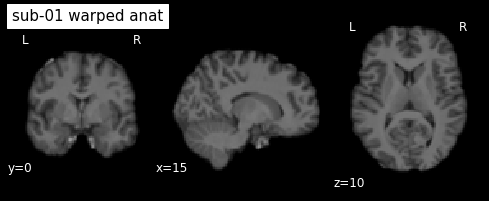

In [76]:
# sanity check - plot the warped anat a sbj
sbj = "sub-01"

plotting.plot_anat(anat_dict.get(sbj), title = f"{sbj} warped anat", 
                   draw_cross = False, black_bg = True, cut_coords = (15, 0, 10))

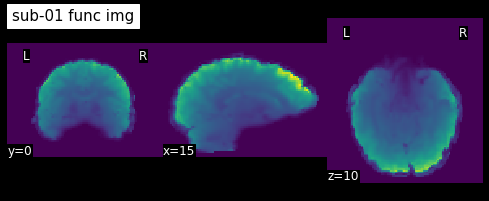

In [77]:
# sanity check - plot the preprocessed func file of a sbj
sbj = "sub-01"

func_img_mean = image.mean_img(AON_run_01_dict.get(sbj))
plotting.plot_img(func_img_mean, title = f"{sbj} func img", 
                   draw_cross = False, black_bg = True, cut_coords = (15, 0, 10))

### Load the realignment parameters

In [ ]:
# create a function to load the motion parameters as pandas dataframes
def MyMotionParameters(paths):
    ''' 
    Returns a dictionary with the motion parameters of each subject for a task/run
    loaded as a pandas dataframe.
    Inputs: A list of paths to the motion parameters
    '''
    pars_dict = {}
    for i, p in enumerate(paths):
        # load the motion parameters as txt
        par = np.loadtxt(p)
        # create a pd.DataFrame with column names of the motion parameters
        par = pd.DataFrame(par)
        par.columns =['x', 'y', 'z', 'pitch', 'roll', 'yaw']
        if i < 10: 
            pars_dict[f"sub-0{i+1}"] = par
        elif i >= 10:
            pars_dict[f"sub-{i+1}"] = par
    return pars_dict

In [105]:
# store paths of AON_run-01 realignment parameters in a list and use the function to load the motion parameters of AON_run-01
AON_run_01_pars_path = sorted(glob(f"{outputdir}/*/AON_run-01.feat/mc/prefiltered_func_data_mcf.par"))
AON_run_01_pars_dict = MyMotionParameters(AON_run_01_pars_path)
AON_run_01_pars_dict

################################
# same for action & AON_run-02 #
################################

{'sub-01':             x         y         z     pitch      roll       yaw
 0   -0.000433 -0.000647  0.000409 -0.007245 -0.052879  0.077684
 1   -0.000318 -0.000624  0.000000 -0.007122 -0.065449  0.087789
 2   -0.000445 -0.000203  0.000000 -0.024502 -0.057636  0.089950
 3   -0.000235 -0.000311  0.000000 -0.016416 -0.043508  0.102743
 4   -0.000647 -0.000510  0.000230 -0.017348 -0.061869  0.105824
 ..        ...       ...       ...       ...       ...       ...
 268 -0.000764 -0.000210 -0.000213 -0.012742  0.023248 -0.031369
 269 -0.000438 -0.000305 -0.000189 -0.017838  0.057025 -0.007936
 270 -0.001066 -0.000449 -0.000036 -0.018732  0.000531 -0.041197
 271 -0.000383 -0.000283 -0.000118 -0.009230  0.065558 -0.023081
 272 -0.000624 -0.000032  0.000000 -0.017045  0.024726 -0.013321
 
 [273 rows x 6 columns]}

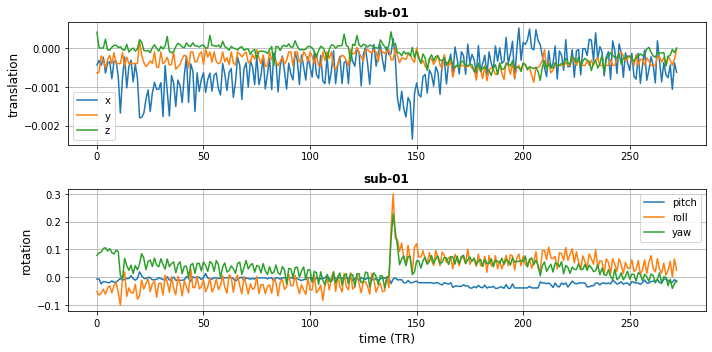

In [106]:
# sanity check - plot the motion parameters

for i in range(0,len(AON_run_01_pars_dict)):
    for sub, pars in AON_run_01_pars_dict.items():
        fig, axes = plt.subplots(nrows=2*len(AON_run_01_pars_dict), ncols=1, figsize=(10,5))
        axes[i].plot(pars[["x","y","z"]])
        axes[i+1].plot(pars[["pitch","roll","yaw"]])
        
        axes[i].set_ylabel("translation", fontsize = 12)
        axes[i+1].set_ylabel("rotation", fontsize = 12)
        axes[i+1].set_xlabel("time (TR)", fontsize = 12)

        axes[i].legend(["x","y","z"])
        axes[i+1].legend(["pitch","roll","yaw"])
  
        axes[i].set_title(sub, fontsize = 12, fontweight ='bold')
        axes[i+1].set_title(sub, fontsize = 12, fontweight ='bold')

        axes[i].grid()
        axes[i+1].grid()
        
        fig.tight_layout()

### Load the events.tsv files

In [114]:
# create a function to load the motion parameters as pandas dataframes
def MyEventFiles(paths):
    ''' 
    Returns a dictionary with the event files of each subject for a task/run
    loaded as a pandas dataframe.
    Inputs: A list of paths to the motion parameters
    '''
    events_dict = {}
    for i, p in enumerate(paths):
        # load events.tsv files
        events = pd.read_table(p)
        if i < 10: 
            events_dict[f"sub-0{i+1}"] = events
        elif i >= 10:
            events_dict[f"sub-{i+1}"] = events
    return events_dict

In [116]:
# load paths of AON_run-01 event files in a list and use the function to store them in a dict
AON_run_01_events_path = sorted(glob(f"{datadir}/*/func/*_task-AON_run-01_events.tsv"))
AON_run_01_events_dict = MyEventFiles(AON_run_01_events_path)

In [118]:
# sanity check - inspect events.tsv file of a subject
sbj = "sub-01"
events = AON_run_01_events_dict.get(sbj)

# display shape of events file
print(events.shape)

# display 5 first and last values of each column
events.head(5)

(18, 12)


,onset,duration,offset,condition,trial_type,participant_id,date,session,attempt,run,dur_fixation,task_duration
0,5.044104,14.957332,20.001436,8,Human Scrambled,sub-01,2020-09-24-13-05-19,1,1,1,5,324.932103
1,25.036297,12.431768,37.468065,1,Dog Goal-directed,sub-01,2020-09-24-13-05-19,1,1,1,3,324.932103
2,40.503415,12.715053,53.218468,5,Dog Ghost,sub-01,2020-09-24-13-05-19,1,1,1,4,324.932103
3,57.252661,12.649943,69.902604,3,Dog Miming,sub-01,2020-09-24-13-05-19,1,1,1,5,324.932103
4,74.934853,12.816701,87.751554,7,Dog Scrambled,sub-01,2020-09-24-13-05-19,1,1,1,6,324.932103


Now everything should be set and ready to fit the first level model! :)

## First level model of one subject

In [142]:
# I used the TR from the experiment, and for all other params I used the default values
first_level = FirstLevelModel(t_r=1.2,
                              hrf_model="spm",
                              drift_model="cosine",
                              minimize_memory = False) # for voxelwise attributes like R-Squared

In [143]:
# fit first level model of sub-01
sbj = "sub-01"
first_level_fit = first_level.fit(AON_run_01_dict.get(sbj), events = AON_run_01_events_dict.get(sbj), confounds = AON_run_01_pars_dict.get(sbj))

/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `dur_fixation` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `participant_id` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `condition` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `session` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpecte

(273, 21)


<AxesSubplot:label='conditions', ylabel='scan number'>

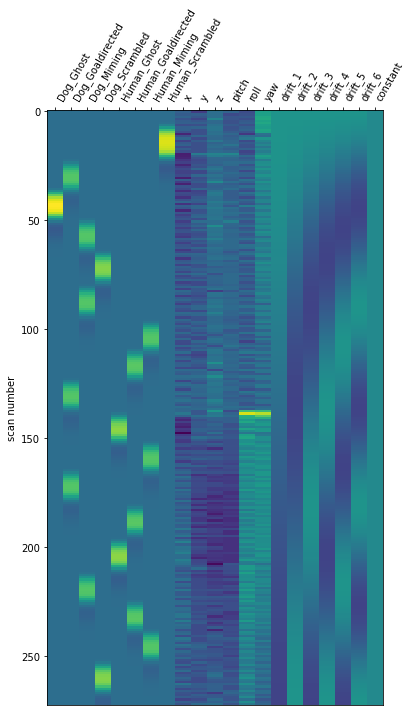

In [144]:
# we choose the first design matrix (model is implicitly ment for multiple run, we only analysed one run)
design_matrix = first_level_fit.design_matrices_[0]
# print the shape of the design matrix
print(np.shape(design_matrix))
# plot the design matrix
plotting.plot_design_matrix(design_matrix)

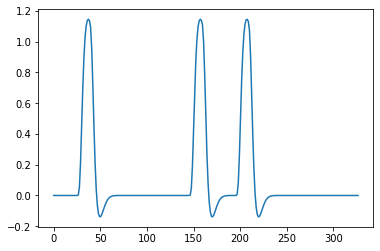

In [145]:
# plot an exemplary HRF
plt.plot(design_matrix["Dog_Goaldirected"])

#### Looks good, let's calculate and plot some contrasts as safety checks

1. Main conditions > Baseline
2. Motion parameters > Baseline

In [146]:
# print indices of columns of interst
print("Dog transitive index: ", design_matrix.columns.get_loc("Dog_Goaldirected"))
print("Dog intransitive index: ", design_matrix.columns.get_loc("Dog_Miming"))
print("Human transitive index: ", design_matrix.columns.get_loc("Human_Goaldirected"))
print("Human intransitive index: ", design_matrix.columns.get_loc("Human_Miming"))
print("motion_parameter_index x: ", design_matrix.columns.get_loc("x"))
print("motion_parameter_index y: ", design_matrix.columns.get_loc("y"))
print("motion_parameter_index z: ", design_matrix.columns.get_loc("z"))
print("motion_parameter_index pitch: ", design_matrix.columns.get_loc("pitch"))
print("motion_parameter_index roll: ", design_matrix.columns.get_loc("roll"))
print("motion_parameter_index yaw: ", design_matrix.columns.get_loc("yaw"))

Dog transitive index:  1
Dog intransitive index:  2
Human transitive index:  5
Human intransitive index:  6
motion_parameter_index x:  8
motion_parameter_index y:  9
motion_parameter_index z:  10
motion_parameter_index pitch:  11
motion_parameter_index roll:  12
motion_parameter_index yaw:  13


In [147]:
# setup contrast dictonary
contrasts = {
  "Main conditions > baseline": np.array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  "Motion pars > baseline": np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
}

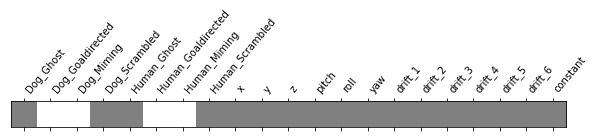

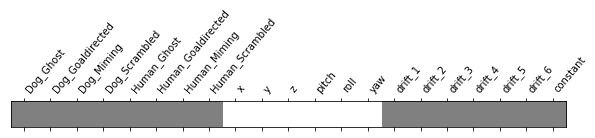

In [148]:
# plot the contrast matrix
for id, val in contrasts.items():
  plotting.plot_contrast_matrix(val, design_matrix=design_matrix)

contrast id: Main conditions > baseline
contrast val: [0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


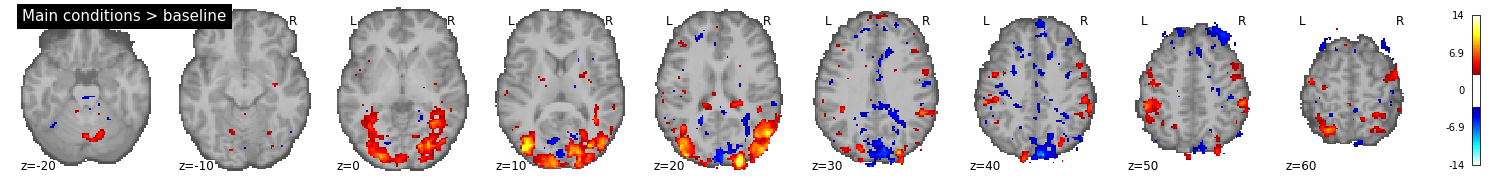

contrast id: Motion pars > baseline
contrast val: [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


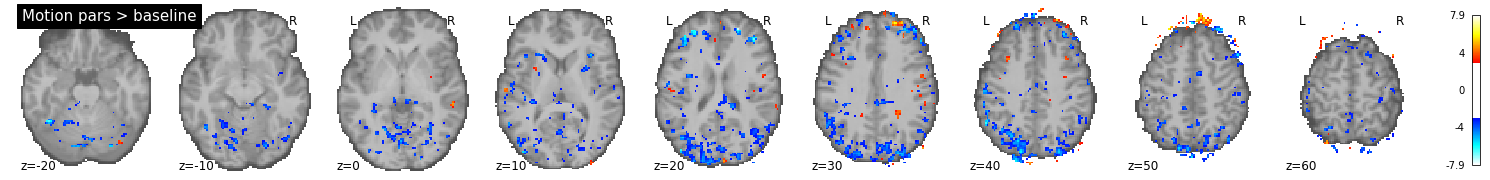

In [159]:
# plotting the contrast maps for each condition

for contrast_id, contrast_val in contrasts.items():
    print(f"contrast id: {contrast_id}")
    print(f"contrast val: {contrast_val}")
    
    # compute the contrasts
    z_map = first_level.compute_contrast(contrast_val, 
                                      output_type='z_score')
    # plot the contrasts 
    # the display is overlaid on the warped anatomical
    plotting.plot_stat_map(
        z_map, 
        bg_img=anat_dict.get(sbj), 
        threshold=3.0, 
        display_mode='z',
        cut_coords=range(-20, 70, 10), 
        black_bg=False, 
        title=contrast_id,
        symmetric_cbar=True)
    plotting.show()

**Trying the save GLM to BIDS function**

In [155]:
from nilearn.interfaces.bids import save_glm_to_bids

save_glm_to_bids(
    first_level,
    contrasts=contrasts.get("Main conditions > baseline"),
    #contrast_types={'StopSuccess - Go': 't'},
    out_dir=f"{outputdir}/nilearn_glm/",
    prefix=sbj + '_task-AON_run-01')

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [156]:
contrasts.get("Main conditions > baseline")

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])